In [ ]:
# Install packages
!pip install yfinance pandas matplotlib seaborn streamlit riskfolio-lib

# Install libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import riskfolio.Portfolio as pf
    riskfolio_available = True
except ImportError:
    riskfolio_available = False

Configuration of Tickers & Dates

In [5]:
# ✏️ EDIT HERE: You can change these tickers anytime
tickers = {
    "Arista Networks": "ANET",
    "Fabrinet": "FN",
    "Astera Labs": "ALAB",
    "NVIDIA": "NVDA"
}

start_date = "2010-01-01"
end_date = "2024-12-31"

# Options:
freq = "Yearly"  # Options: Daily, Monthly, Yearly
abs_or_pct = "% Change (Relative)"  # or "Price Difference (Absolute)"
overlap = "No"  # "Yes" for overlapping YoY
correlation_method = "pearson"  # Options: "pearson", "kendall", "spearman"
rolling_window = 60  # Rolling window in days

Data Download from Yahoo Finance

In [ ]:
data = {}
for name, ticker in tickers.items():
    print(f"📥 Downloading {name} ({ticker})...")
    stock = yf.download(ticker, start=start_date, end=end_date, group_by="column", auto_adjust=True)
    if not stock.empty:
        if "Adj Close" in stock.columns:
            data[name] = stock["Adj Close"].squeeze()
        elif "Close" in stock.columns:
            print(f"⚠️ {ticker} missing 'Adj Close'. Using 'Close' instead.")
            data[name] = stock["Close"].squeeze()
        else:
            print(f"❌ {ticker} has no usable price column.")
    else:
        print(f"❌ {ticker} returned no data.")

📥 Downloading Apple (AAPL)...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


⚠️ AAPL missing 'Adj Close'. Using 'Close' instead.
📥 Downloading Tesla (TSLA)...
⚠️ TSLA missing 'Adj Close'. Using 'Close' instead.
📥 Downloading Microsoft (MSFT)...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


⚠️ MSFT missing 'Adj Close'. Using 'Close' instead.
📥 Downloading Amazon (AMZN)...
⚠️ AMZN missing 'Adj Close'. Using 'Close' instead.
📥 Downloading NVIDIA (NVDA)...


[*********************100%***********************]  1 of 1 completed

⚠️ NVDA missing 'Adj Close'. Using 'Close' instead.


Dataframe formation

In [6]:
if len(data) == 0:
    print("❌ No valid data downloaded.")
else:
    df = pd.DataFrame(data).dropna()
    df.to_csv("prices.csv")
    display(df.tail())

,Apple,Tesla,Microsoft,Amazon,NVIDIA
Date,,,,,
2024-12-24,257.578674,462.279999,437.647369,229.050003,140.207108
2024-12-26,258.396667,454.130005,436.432068,227.050003,139.917130
2024-12-27,254.974930,431.660004,428.881104,223.750000,136.997391
2024-12-30,251.593094,417.410004,423.202911,221.300003,137.477356
2024-12-31,249.817383,403.839996,419.885681,219.389999,134.277649


Return Calculation (based on frequency and method)

In [7]:
if freq == "Daily":
    temp = df
elif freq == "Monthly":
    temp = df.resample("M").last()
elif freq == "Yearly":
    temp = df.resample("Y").last()

if abs_or_pct == "% Change (Relative)":
    if freq == "Yearly" and overlap == "Yes":
        returns = df.pct_change(252).dropna()
    else:
        returns = temp.pct_change().dropna()
else:
    returns = temp.diff().dropna()

# 🧼 Remove October data due to options pollution
returns = returns[returns.index.month != 10]

# 📏 Warn if not enough data points
if len(returns) < 30:
    print("⚠️ Fewer than 30 data points — correlation may be unreliable.")


⚠️ Fewer than 30 data points — correlation may be unreliable.


C:\Users\genin\AppData\Local\Temp\ipykernel_25316\1128550481.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  temp = df.resample("Y").last()


Correlation Matrix

,Apple,Tesla,Microsoft,Amazon,NVIDIA
Apple,1.000,0.990,0.929,0.895,0.973
Tesla,0.990,1.000,0.883,0.948,0.996
Microsoft,0.929,0.883,1.000,0.731,0.843
Amazon,0.895,0.948,0.731,1.000,0.973
NVIDIA,0.973,0.996,0.843,0.973,1.000


C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


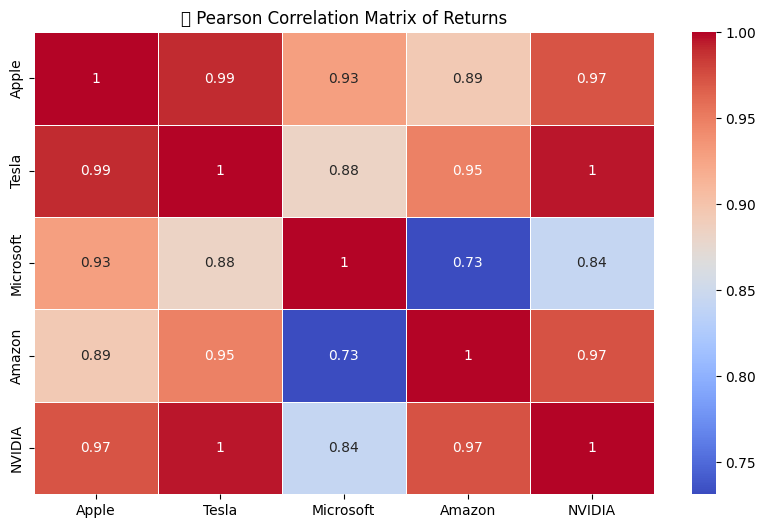

In [8]:
corr_matrix = returns.corr(method=correlation_method)
display(corr_matrix.round(3))

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title(f"🔗 {correlation_method.title()} Correlation Matrix of Returns")
plt.show()

Rolling Correlation

In [ ]:
if "NVIDIA" in returns.columns and "Arista Networks" in returns.columns:
    rolling_corr = returns["NVIDIA"].rolling(rolling_window).corr(returns["Arista Networks"])
    rolling_corr.plot(title="🔁 Rolling Correlation: NVIDIA vs Arista", figsize=(10, 4))
    plt.axhline(0, color='gray', linestyle='--')
    plt.grid(True)
    plt.show()

Risk Metrics & Portfolio Optimization

In [ ]:
if riskfolio_available:
    port = pf.Portfolio(returns=returns)
    port.assets_stats(method_mu='hist', method_cov='hist')
    risk = port.risk_measures(method='hist', rf=0)
    display(risk[["VaR_0.05", "CVaR_0.05", "Sharpe"]].round(4))

    # Optimization
    w = port.optimization(model="Classic", rm="MV", obj="Sharpe", hist=True)
    display(w.T.round(4))

    # Portfolio performance
    port_weights = w[w > 0].index.tolist()
    weighted_returns = returns[port_weights].mul(w.T[port_weights].values, axis=1).sum(axis=1)
    cumulative_returns = (1 + weighted_returns).cumprod()
    cumulative_returns.plot(title="📈 Optimized Portfolio Cumulative Returns", figsize=(10, 4))
    plt.grid(True)
    plt.show()

    # Drawdown chart
    drawdown = (cumulative_returns - cumulative_returns.cummax()) / cumulative_returns.cummax()
    drawdown.plot(title="📉 Drawdown from Peak", figsize=(10, 4), color="red")
    plt.grid(True)
    plt.show()

    # Rebalancing simulation
    rebalance_returns = weighted_returns.resample("M").apply(lambda x: (1 + x).prod() - 1)
    rebalance_cumulative = (1 + rebalance_returns).cumprod()
    rebalance_cumulative.plot(title="🔁 Monthly Rebalanced Portfolio", figsize=(10, 4))
    plt.grid(True)
    plt.show()
else:
    print("⚠️ Install riskfolio-lib to enable risk metrics.")